# Priprava knjižnic

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import tempfile
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont, ImageColor, ImageOps
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')
print(tf.__version__)

2.5.0


## Uporabljene zbirke podatkov
- Object Detection models trained on COCO 2017 dataset https://tfhub.dev/tensorflow/collections/object_detection/1

# Nalaganje in obdelava slike

In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_image(url, display=True, new_width=1000, new_height=800):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=100)
  print(f"Image downloaded to {filename}.")

  if display:
    display_image(pil_image)
  return filename


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)
  
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = f"{labels[class_names[i]]['name']}: {int(100 * scores[i])}%"
      color = colors[hash(labels[class_names[i]]['name']) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


# Prenos slike iz URL-ja

Image downloaded to /tmp/tmppho4uu1w.jpg.


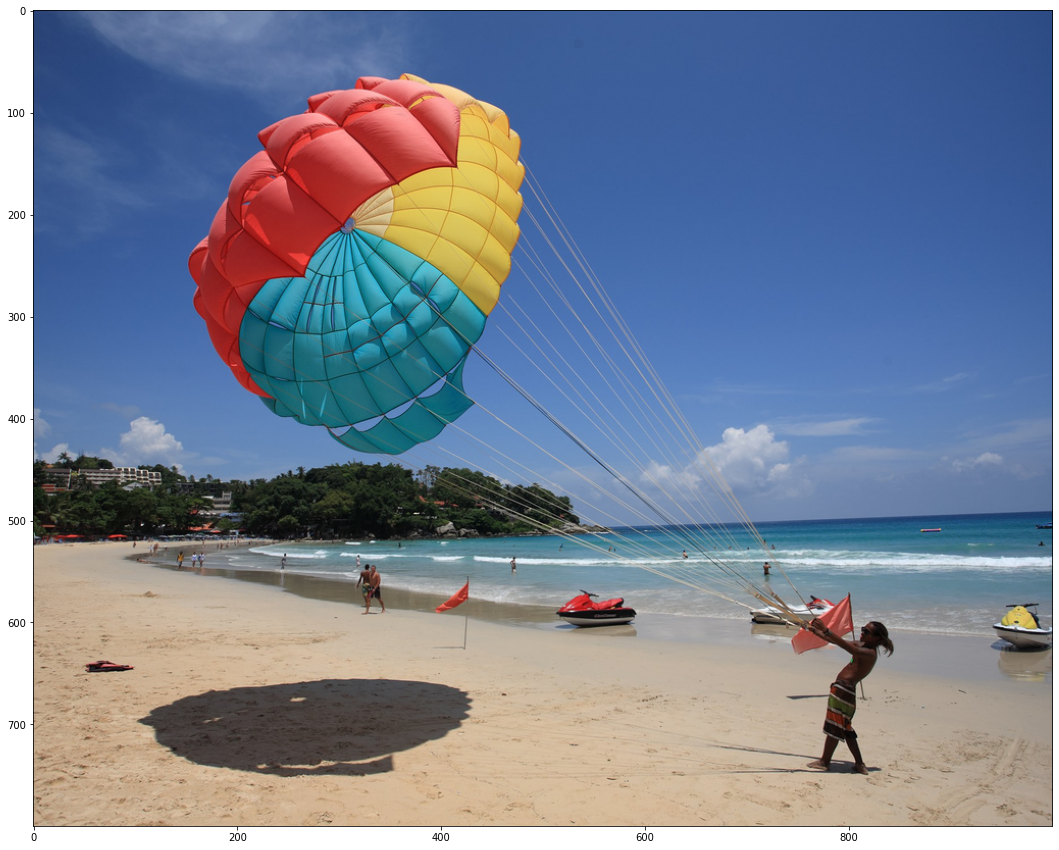

In [3]:
# image_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallup.net%2Fwp-content%2Fuploads%2F2017%2F11%2F17%2F199174-Philadelphia-HDR-indoors-table-chair-restaurant.jpg&f=1&nofb=1" # @param
image_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fbest-wallpaper.net%2Fwallpaper%2F1920x1440%2F1811%2FBeach-sea-people-parachute_1920x1440.jpg&f=1&nofb=1" # @param
# image_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fqph.fs.quoracdn.net%2Fmain-qimg-d8d94f452bd35643e2bfb70b18d00c08&f=1&nofb=1" # @param

downloaded_image = download_image(image_url)

# Nalaganje modela za detekcijo

In [4]:
AVAILABLE_MODELS = {
  'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
  'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
  'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
  'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
  'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
  'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
  'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
  'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
  'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
  'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
  'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
  'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
  'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
  'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
  'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
  'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
  'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
  'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
  'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
  'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
  'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
  'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
  'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
  'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
  'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
  'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
  'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
  'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
  'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
  'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
  'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
  'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
  'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
  'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
  'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
  'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
  'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
  'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
  'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

model_display_name = 'Faster R-CNN Inception ResNet V2 1024x1024' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = AVAILABLE_MODELS[model_display_name]

object_detector = hub.load(model_handle)

In [5]:
object_labels_file_url = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt"

object_labels_file = urlopen(object_labels_file_url)

object_labels = object_labels_file.read()

labels = {1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name': 'frisbee'}, 35: {'id': 35, 'name': 'skis'}, 36: {'id': 36, 'name': 'snowboard'}, 37: {'id': 37, 'name': 'sports ball'}, 38: {'id': 38, 'name': 'kite'}, 39: {'id': 39, 'name': 'baseball bat'}, 40: {'id': 40, 'name': 'baseball glove'}, 41: {'id': 41, 'name': 'skateboard'}, 42: {'id': 42, 'name': 'surfboard'}, 43: {'id': 43, 'name': 'tennis racket'}, 44: {'id': 44, 'name': 'bottle'}, 46: {'id': 46, 'name': 'wine glass'}, 47: {'id': 47, 'name': 'cup'}, 48: {'id': 48, 'name': 'fork'}, 49: {'id': 49, 'name': 'knife'}, 50: {'id': 50, 'name': 'spoon'}, 51: {'id': 51, 'name': 'bowl'}, 52: {'id': 52, 'name': 'banana'}, 53: {'id': 53, 'name': 'apple'}, 54: {'id': 54, 'name': 'sandwich'}, 55: {'id': 55, 'name': 'orange'}, 56: {'id': 56, 'name': 'broccoli'}, 57: {'id': 57, 'name': 'carrot'}, 58: {'id': 58, 'name': 'hot dog'}, 59: {'id': 59, 'name': 'pizza'}, 60: {'id': 60, 'name': 'donut'}, 61: {'id': 61, 'name': 'cake'}, 62: {'id': 62, 'name': 'chair'}, 63: {'id': 63, 'name': 'couch'}, 64: {'id': 64, 'name': 'potted plant'}, 65: {'id': 65, 'name': 'bed'}, 67: {'id': 67, 'name': 'dining table'}, 70: {'id': 70, 'name': 'toilet'}, 72: {'id': 72, 'name': 'tv'}, 73: {'id': 73, 'name': 'laptop'}, 74: {'id': 74, 'name': 'mouse'}, 75: {'id': 75, 'name': 'remote'}, 76: {'id': 76, 'name': 'keyboard'}, 77: {'id': 77, 'name': 'cell phone'}, 78: {'id': 78, 'name': 'microwave'}, 79: {'id': 79, 'name': 'oven'}, 80: {'id': 80, 'name': 'toaster'}, 81: {'id': 81, 'name': 'sink'}, 82: {'id': 82, 'name': 'refrigerator'}, 84: {'id': 84, 'name': 'book'}, 85: {'id': 85, 'name': 'clock'}, 86: {'id': 86, 'name': 'vase'}, 87: {'id': 87, 'name': 'scissors'}, 88: {'id': 88, 'name': 'teddy bear'}, 89: {'id': 89, 'name': 'hair drier'}, 90: {'id': 90, 'name': 'toothbrush'}}


# Poganjanje detekcije

In [6]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [7]:
def run_detector(object_detector, path):
  img = load_img(path)
  converted_img = load_image_into_numpy_array(Image.open(path))
  result = object_detector(converted_img)

  result = {key:value.numpy() for key,value in result.items()}
  print(result.keys())
  print(f"Found {len(result['detection_scores'][0])} objects.")

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"][0],
      result["detection_classes"][0], result["detection_scores"][0])

  display_image(image_with_boxes)

dict_keys(['raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_classes', 'num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores'])
Found 100 objects.


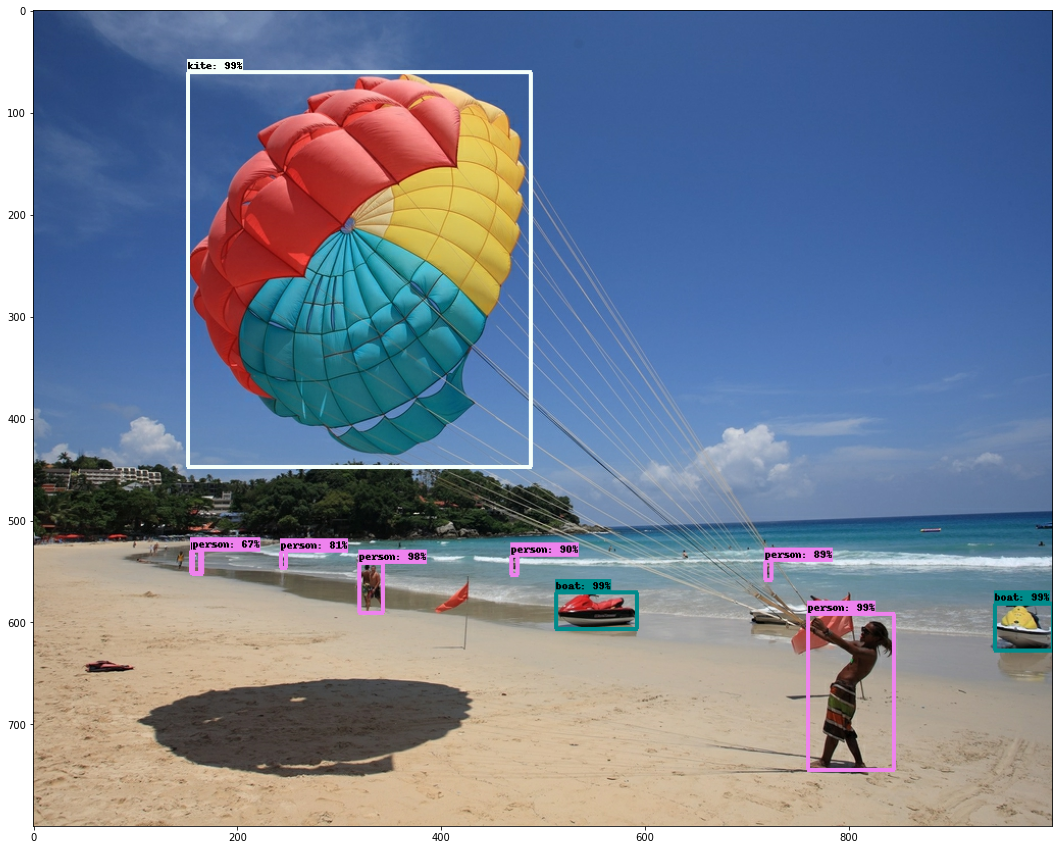

In [8]:
run_detector(object_detector, downloaded_image)